In [1]:
# ## Cell 1: Import libraries and set constants

# In[1]:


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os
import random
from tqdm import tqdm
from utils import plot_tsne

# Set constants
NUM_CLASSES = 10
LATENT_DIM = 128
BATCH_SIZE = 64
EPOCHS_AE = 30
EPOCHS_CLS = 20
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
SEED = 42

# Set device - FIXED: Removed MPS check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

def freeze_seeds(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
freeze_seeds(SEED)

Using device: cuda


In [2]:
# ## Cell 2: Define the Encoder

# In[2]:


class Encoder(nn.Module):
    def __init__(self, in_channels, latent_dim):
        """
        Encoder network for the autoencoder.
        
        Args:
            in_channels: Number of input channels (1 for MNIST, 3 for CIFAR10)
            latent_dim: Dimension of the latent space (128 as per requirements)
        """
        super(Encoder, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Calculate the size of the flattened features
        if in_channels == 1:  # MNIST
            self.fc_input_size = 128 * 4 * 4
        else:  # CIFAR10
            self.fc_input_size = 128 * 4 * 4
        
        # Fully connected layer to latent space
        self.fc = nn.Linear(self.fc_input_size, latent_dim)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

In [3]:
# ## Cell 3: Define the Decoder

# In[3]:


class Decoder(nn.Module):
    def __init__(self, latent_dim, out_channels):
        """
        Decoder network for the autoencoder.
        """
        super(Decoder, self).__init__()
        
        # Same initial settings
        self.initial_size = 4
        self.fc_input_size = 128 * self.initial_size * self.initial_size
        self.fc = nn.Linear(latent_dim, self.fc_input_size)
        
        # First two layers remain the same for both datasets
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        # Precise dimensions for MNIST vs CIFAR10
        if out_channels == 1:  # MNIST needs 28×28 output
            # This will output exactly 28×28
            self.deconv3 = nn.ConvTranspose2d(32, out_channels, kernel_size=1, stride=1)
            self.final_crop = True
        else:  # CIFAR10 needs 32×32 output
            self.deconv3 = nn.ConvTranspose2d(32, out_channels, kernel_size=4, stride=2, padding=1)
            self.final_crop = False
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 128, self.initial_size, self.initial_size)  # 4×4
        x = F.relu(self.bn1(self.deconv1(x)))  # 8×8
        x = F.relu(self.bn2(self.deconv2(x)))  # 16×16
        
        if self.final_crop:  # MNIST case
            # First upsample to 32×32
            x = F.interpolate(x, size=(28, 28), mode='bilinear', align_corners=False)
            # Then apply the final convolution to keep channel dimensions
            x = torch.tanh(self.deconv3(x))  # Still 28×28
        else:  # CIFAR10 case
            x = torch.tanh(self.deconv3(x))  # 32×32
            
        return x

In [4]:
# ## Cell 4: Define the Autoencoder

# In[4]:


class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        """
        Complete autoencoder model.
        
        Args:
            encoder: Encoder network
            decoder: Decoder network
        """
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

In [5]:
# ## Cell 5: Define the Classifier

# In[5]:


class Classifier(nn.Module):
    def __init__(self, latent_dim, num_classes):
        """
        Classifier that uses the latent representation from the encoder.
        
        Args:
            latent_dim: Dimension of the latent space
            num_classes: Number of output classes (10 for both MNIST and CIFAR10)
        """
        super(Classifier, self).__init__()
        
        # Simple MLP classifier
        self.fc1 = nn.Linear(latent_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [6]:
# ## Cell 6: Training and Evaluation Functions

# In[6]:


def train_autoencoder(model, train_loader, val_loader, num_epochs, device, lr=1e-3, weight_decay=1e-5):
    """
    Train the autoencoder model.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    mse_criterion = nn.MSELoss()
    
    model.train()
    mse_losses = []
    mae_losses = []
    val_mse_losses = []
    val_mae_losses = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        epoch_mse_loss = 0.0
        epoch_mae_loss = 0.0
        num_batches = 0
        
        for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            data = data.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            reconstructed, _ = model(data)
            mse_loss = mse_criterion(reconstructed, data)
            
            # Calculate MAE for reporting (not used for optimization)
            mae_loss = torch.mean(torch.abs(reconstructed - data))
            
            # Backward pass and optimize
            mse_loss.backward()
            optimizer.step()
            
            epoch_mse_loss += mse_loss.item()
            epoch_mae_loss += mae_loss.item()
            num_batches += 1
        
        avg_epoch_mse_loss = epoch_mse_loss / num_batches
        avg_epoch_mae_loss = epoch_mae_loss / num_batches
        mse_losses.append(avg_epoch_mse_loss)
        mae_losses.append(avg_epoch_mae_loss)
        
        # Validation
        model.eval()
        val_epoch_mse_loss = 0.0
        val_epoch_mae_loss = 0.0
        val_num_batches = 0
        
        with torch.no_grad():
            for val_data, _ in val_loader:
                val_data = val_data.to(device)
                val_reconstructed, _ = model(val_data)
                
                val_mse_loss = mse_criterion(val_reconstructed, val_data)
                val_mae_loss = torch.mean(torch.abs(val_reconstructed - val_data))
                
                val_epoch_mse_loss += val_mse_loss.item()
                val_epoch_mae_loss += val_mae_loss.item()
                val_num_batches += 1
        
        avg_val_epoch_mse_loss = val_epoch_mse_loss / val_num_batches
        avg_val_epoch_mae_loss = val_epoch_mae_loss / val_num_batches
        val_mse_losses.append(avg_val_epoch_mse_loss)
        val_mae_losses.append(avg_val_epoch_mae_loss)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train MSE: {avg_epoch_mse_loss:.6f}, Train MAE: {avg_epoch_mae_loss:.6f}, Val MSE: {avg_val_epoch_mse_loss:.6f}, Val MAE: {avg_val_epoch_mae_loss:.6f}")
    
    return model, mse_losses, mae_losses, val_mse_losses, val_mae_losses

def train_classifier(encoder, classifier, train_loader, val_loader, num_epochs, device, lr=1e-3, weight_decay=1e-5):
    """
    Train the classifier using the encoder's latent representations.
    """
    optimizer = optim.Adam(classifier.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    
    encoder.eval()  # Freeze the encoder
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training
        classifier.train()
        epoch_loss = 0.0
        correct = 0
        total = 0
        num_batches = 0
        
        for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            data, targets = data.to(device), targets.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            with torch.no_grad():
                latent = encoder(data)  # Get latent representation (no gradients)
            
            outputs = classifier(latent)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        avg_epoch_loss = epoch_loss / num_batches
        epoch_accuracy = 100.0 * correct / total
        
        train_losses.append(avg_epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        # Validation
        classifier.eval()
        val_epoch_loss = 0.0
        val_correct = 0
        val_total = 0
        val_num_batches = 0
        
        with torch.no_grad():
            for val_data, val_targets in val_loader:
                val_data, val_targets = val_data.to(device), val_targets.to(device)
                
                val_latent = encoder(val_data)
                val_outputs = classifier(val_latent)
                val_loss = criterion(val_outputs, val_targets)
                
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_targets.size(0)
                val_correct += (val_predicted == val_targets).sum().item()
                
                val_epoch_loss += val_loss.item()
                val_num_batches += 1
        
        avg_val_epoch_loss = val_epoch_loss / val_num_batches
        val_epoch_accuracy = 100.0 * val_correct / val_total
        
        val_losses.append(avg_val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_epoch_loss:.6f}, Train Acc: {epoch_accuracy:.2f}%, Val Loss: {avg_val_epoch_loss:.6f}, Val Acc: {val_epoch_accuracy:.2f}%")
    
    return classifier, train_losses, train_accuracies, val_losses, val_accuracies

def evaluate_classifier(encoder, classifier, dataloader, device):
    """
    Evaluate the classifier on a test dataset.
    """
    encoder.eval()
    classifier.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, targets in tqdm(dataloader, desc="Evaluating"):
            data, targets = data.to(device), targets.to(device)
            
            # Get latent representation
            latent = encoder(data)
            
            # Forward pass through classifier
            outputs = classifier(latent)
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    accuracy = 100.0 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    return accuracy

In [7]:
# ## Cell 7: Visualization Functions

# In[7]:


def plot_training_curve(losses, val_losses, title, ylabel, save_path=None):
    """
    Plot training and validation curves.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    
    if save_path:
        plt.savefig(save_path)
        
    plt.show()

def plot_reconstructions(model, dataloader, device, num_samples=5, save_path=None):
    """
    Plot original images and their reconstructions.
    """
    model.eval()
    
    # Get a batch of images
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    images = images[:num_samples].to(device)
    labels = labels[:num_samples]
    
    # Reconstruct images
    with torch.no_grad():
        reconstructions, _ = model(images)
    
    # Move to CPU and convert to numpy for plotting
    images = images.cpu().numpy()
    reconstructions = reconstructions.cpu().numpy()
    
    # Plot original and reconstructed images
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))
    
    for i in range(num_samples):
        # Plot original
        img = np.transpose(images[i], (1, 2, 0))  # CHW -> HWC
        img = (img + 1) / 2.0  # Scale from [-1, 1] to [0, 1]
        if img.shape[2] == 1:  # Grayscale
            img = img.squeeze(2)
            axes[0, i].imshow(img, cmap='gray')
        else:  # RGB
            axes[0, i].imshow(img)
        axes[0, i].set_title(f"Label: {labels[i].item()}")
        axes[0, i].axis('off')
        
        # Plot reconstruction
        recon = np.transpose(reconstructions[i], (1, 2, 0))  # CHW -> HWC
        recon = (recon + 1) / 2.0  # Scale from [-1, 1] to [0, 1]
        if recon.shape[2] == 1:  # Grayscale
            recon = recon.squeeze(2)
            axes[1, i].imshow(recon, cmap='gray')
        else:  # RGB
            axes[1, i].imshow(recon)
        axes[1, i].axis('off')
    
    axes[0, 0].set_ylabel('Original')
    axes[1, 0].set_ylabel('Reconstructed')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()
    
    return images, labels

def latent_interpolation(encoder, decoder, img1, img2, steps=10, device=device, save_path=None):
    """
    Perform linear interpolation in the latent space between two images.
    
    Args:
        encoder: Trained encoder model
        decoder: Trained decoder model
        img1: First image tensor
        img2: Second image tensor
        steps: Number of interpolation steps
        device: Device to use
        save_path: Path to save the interpolation plot
    """
    # Ensure images are tensors on the correct device
    img1 = img1.unsqueeze(0).to(device) if not isinstance(img1, torch.Tensor) else img1.to(device)
    img2 = img2.unsqueeze(0).to(device) if not isinstance(img2, torch.Tensor) else img2.to(device)
    
    if len(img1.shape) == 3:
        img1 = img1.unsqueeze(0)
    if len(img2.shape) == 3:
        img2 = img2.unsqueeze(0)
    
    # Encode images
    with torch.no_grad():
        latent1 = encoder(img1)
        latent2 = encoder(img2)
    
    # Interpolate between latent vectors
    alphas = torch.linspace(0, 1, steps)
    interpolated_images = []
    
    with torch.no_grad():
        for alpha in alphas:
            # Linear interpolation
            interpolated_latent = (1 - alpha) * latent1 + alpha * latent2
            # Decode
            decoded_img = decoder(interpolated_latent)
            interpolated_images.append(decoded_img.cpu())
    
    # Visualize the interpolation
    fig, axes = plt.subplots(1, steps, figsize=(20, 4))
    
    for i, img in enumerate(interpolated_images):
        img = img.squeeze(0)
        img_np = img.numpy()
        img_np = np.transpose(img_np, (1, 2, 0))  # CHW -> HWC
        img_np = (img_np + 1) / 2.0  # Scale from [-1, 1] to [0, 1]
        
        if img_np.shape[2] == 1:  # Grayscale
            img_np = img_np.squeeze(2)
            axes[i].imshow(img_np, cmap='gray')
        else:  # RGB
            axes[i].imshow(img_np)
        
        axes[i].axis('off')
        axes[i].set_title(f"α={alpha:.1f}" if i == 0 or i == steps-1 else "")
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

def custom_plot_tsne(model, dataloader, device, n_samples=1000, save_path_latent=None, save_path_image=None):
    """
    Custom t-SNE plotting function with a sample limit for efficiency.
    """
    model.eval()
    
    images_list = []
    labels_list = []
    latent_list = []
    
    # Collect data up to n_samples
    with torch.no_grad():
        for data in tqdm(dataloader, desc="Collecting data for t-SNE"):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            # Get latent representation
            latent_vector = model(images)
            
            images_list.append(images.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
            latent_list.append(latent_vector.cpu().numpy())
            
            # Check if we have enough samples
            if sum(len(l) for l in labels_list) >= n_samples:
                break
    
    # Concatenate all batches
    images = np.concatenate(images_list, axis=0)[:n_samples]
    labels = np.concatenate(labels_list, axis=0)[:n_samples]
    latent_vectors = np.concatenate(latent_list, axis=0)[:n_samples]
    
    # Plot TSNE for latent space
    print("Computing t-SNE for latent space...")
    tsne_latent = TSNE(n_components=2, random_state=42)
    latent_tsne = tsne_latent.fit_transform(latent_vectors)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='tab10', s=10)
    plt.colorbar(scatter)
    plt.title('t-SNE of Latent Space')
    plt.grid(True)
    
    if save_path_latent:
        plt.savefig(save_path_latent)
    
    plt.show()
    
    # Plot t-SNE for image space
    print("Computing t-SNE for image space...")
    images_flattened = images.reshape(images.shape[0], -1)
    tsne_image = TSNE(n_components=2, random_state=42)
    image_tsne = tsne_image.fit_transform(images_flattened)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(image_tsne[:, 0], image_tsne[:, 1], c=labels, cmap='tab10', s=10)
    plt.colorbar(scatter)
    plt.title('t-SNE of Image Space')
    plt.grid(True)
    
    if save_path_image:
        plt.savefig(save_path_image)
    
    plt.show()

In [8]:
# ## Cell 8: Setup Dataset (MNIST)

# In[8]:


# Select dataset - set to MNIST
use_mnist = True
DATA_PATH = '/datasets/cv_datasets/data'  # Use server path

# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5] if use_mnist else [0.5, 0.5, 0.5], 
                        std=[0.5] if use_mnist else [0.5, 0.5, 0.5])  # Scale to [-1, 1]
])

# Load dataset
if use_mnist:
    print("Using MNIST dataset")
    train_dataset = datasets.MNIST(root=DATA_PATH, train=True, download=False, transform=transform)
    test_dataset = datasets.MNIST(root=DATA_PATH, train=False, download=False, transform=transform)
    in_channels = 1
else:
    print("Using CIFAR10 dataset")
    train_dataset = datasets.CIFAR10(root=DATA_PATH, train=True, download=False, transform=transform)
    test_dataset = datasets.CIFAR10(root=DATA_PATH, train=False, download=False, transform=transform)
    in_channels = 3

# Split train into train and validation
val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Using MNIST dataset
Train set size: 54000
Validation set size: 6000
Test set size: 10000


In [9]:
# ## Cell 9: Initialize Models

# In[9]:


# Initialize encoder and decoder
encoder = Encoder(in_channels, LATENT_DIM).to(device)
decoder = Decoder(LATENT_DIM, in_channels).to(device)
autoencoder = Autoencoder(encoder, decoder).to(device)
classifier = Classifier(LATENT_DIM, NUM_CLASSES).to(device)

# Print model architectures
print("Encoder Architecture:")
print(encoder)
print("\nDecoder Architecture:")
print(decoder)
print("\nClassifier Architecture:")
print(classifier)

# Check a sample forward pass
sample = next(iter(train_loader))[0][:1].to(device)
print(f"\nSample shape: {sample.shape}")
reconstructed, latent = autoencoder(sample)
print(f"Latent shape: {latent.shape}")
print(f"Reconstructed shape: {reconstructed.shape}")


Encoder Architecture:
Encoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=2048, out_features=128, bias=True)
)

Decoder Architecture:
Decoder(
  (fc): Linear(in_features=128, out_features=2048, bias=True)
  (deconv1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0


--- Training Autoencoder (Self-Supervised) ---


Epoch 1/30: 100%|██████████| 844/844 [00:17<00:00, 48.19it/s]


Epoch [1/30], Train MSE: 0.037482, Train MAE: 0.063629, Val MSE: 0.015935, Val MAE: 0.041464


Epoch 2/30: 100%|██████████| 844/844 [00:17<00:00, 49.21it/s]


Epoch [2/30], Train MSE: 0.014494, Train MAE: 0.039503, Val MSE: 0.012624, Val MAE: 0.036982


Epoch 3/30: 100%|██████████| 844/844 [00:17<00:00, 48.98it/s]


Epoch [3/30], Train MSE: 0.012088, Train MAE: 0.035803, Val MSE: 0.012839, Val MAE: 0.036027


Epoch 4/30: 100%|██████████| 844/844 [00:17<00:00, 49.07it/s]


Epoch [4/30], Train MSE: 0.011258, Train MAE: 0.034403, Val MSE: 0.010355, Val MAE: 0.032937


Epoch 5/30: 100%|██████████| 844/844 [00:17<00:00, 49.07it/s]


Epoch [5/30], Train MSE: 0.010480, Train MAE: 0.033132, Val MSE: 0.010225, Val MAE: 0.032410


Epoch 6/30: 100%|██████████| 844/844 [00:17<00:00, 48.97it/s]


Epoch [6/30], Train MSE: 0.009932, Train MAE: 0.032125, Val MSE: 0.010259, Val MAE: 0.032100


Epoch 7/30: 100%|██████████| 844/844 [00:17<00:00, 49.02it/s]


Epoch [7/30], Train MSE: 0.009494, Train MAE: 0.031273, Val MSE: 0.010238, Val MAE: 0.032807


Epoch 8/30: 100%|██████████| 844/844 [00:17<00:00, 48.73it/s]


Epoch [8/30], Train MSE: 0.009277, Train MAE: 0.030809, Val MSE: 0.009144, Val MAE: 0.030745


Epoch 9/30: 100%|██████████| 844/844 [00:17<00:00, 49.37it/s]


Epoch [9/30], Train MSE: 0.008936, Train MAE: 0.030112, Val MSE: 0.009586, Val MAE: 0.031330


Epoch 10/30: 100%|██████████| 844/844 [00:17<00:00, 49.37it/s]


Epoch [10/30], Train MSE: 0.008653, Train MAE: 0.029557, Val MSE: 0.008500, Val MAE: 0.029064


Epoch 11/30: 100%|██████████| 844/844 [00:17<00:00, 49.37it/s]


Epoch [11/30], Train MSE: 0.008487, Train MAE: 0.029207, Val MSE: 0.008372, Val MAE: 0.028930


Epoch 12/30: 100%|██████████| 844/844 [00:17<00:00, 49.53it/s]


Epoch [12/30], Train MSE: 0.008132, Train MAE: 0.028539, Val MSE: 0.008335, Val MAE: 0.028689


Epoch 13/30: 100%|██████████| 844/844 [00:17<00:00, 49.39it/s]


Epoch [13/30], Train MSE: 0.008011, Train MAE: 0.028291, Val MSE: 0.007830, Val MAE: 0.027820


Epoch 14/30: 100%|██████████| 844/844 [00:17<00:00, 49.10it/s]


Epoch [14/30], Train MSE: 0.007847, Train MAE: 0.027976, Val MSE: 0.008097, Val MAE: 0.028513


Epoch 15/30: 100%|██████████| 844/844 [00:17<00:00, 49.17it/s]


Epoch [15/30], Train MSE: 0.007726, Train MAE: 0.027738, Val MSE: 0.007646, Val MAE: 0.027658


Epoch 16/30: 100%|██████████| 844/844 [00:17<00:00, 48.94it/s]


Epoch [16/30], Train MSE: 0.007607, Train MAE: 0.027508, Val MSE: 0.007955, Val MAE: 0.027974


Epoch 17/30: 100%|██████████| 844/844 [00:17<00:00, 48.94it/s]


Epoch [17/30], Train MSE: 0.007459, Train MAE: 0.027234, Val MSE: 0.008297, Val MAE: 0.029119


Epoch 18/30: 100%|██████████| 844/844 [00:17<00:00, 49.07it/s]


Epoch [18/30], Train MSE: 0.007437, Train MAE: 0.027186, Val MSE: 0.007144, Val MAE: 0.026453


Epoch 19/30: 100%|██████████| 844/844 [00:17<00:00, 49.09it/s]


Epoch [19/30], Train MSE: 0.007326, Train MAE: 0.026977, Val MSE: 0.006955, Val MAE: 0.026265


Epoch 20/30: 100%|██████████| 844/844 [00:17<00:00, 49.05it/s]


Epoch [20/30], Train MSE: 0.007328, Train MAE: 0.026967, Val MSE: 0.006993, Val MAE: 0.026259


Epoch 21/30: 100%|██████████| 844/844 [00:17<00:00, 49.13it/s]


Epoch [21/30], Train MSE: 0.007138, Train MAE: 0.026613, Val MSE: 0.006994, Val MAE: 0.026242


Epoch 22/30: 100%|██████████| 844/844 [00:17<00:00, 49.08it/s]


Epoch [22/30], Train MSE: 0.007118, Train MAE: 0.026567, Val MSE: 0.007617, Val MAE: 0.027790


Epoch 23/30: 100%|██████████| 844/844 [00:17<00:00, 48.69it/s]


Epoch [23/30], Train MSE: 0.007088, Train MAE: 0.026499, Val MSE: 0.007026, Val MAE: 0.026225


Epoch 24/30: 100%|██████████| 844/844 [00:17<00:00, 49.10it/s]


Epoch [24/30], Train MSE: 0.007017, Train MAE: 0.026370, Val MSE: 0.006685, Val MAE: 0.025540


Epoch 25/30: 100%|██████████| 844/844 [00:17<00:00, 49.04it/s]


Epoch [25/30], Train MSE: 0.006950, Train MAE: 0.026238, Val MSE: 0.006843, Val MAE: 0.025972


Epoch 26/30: 100%|██████████| 844/844 [00:17<00:00, 49.00it/s]


Epoch [26/30], Train MSE: 0.006951, Train MAE: 0.026244, Val MSE: 0.006743, Val MAE: 0.025990


Epoch 27/30: 100%|██████████| 844/844 [00:17<00:00, 49.17it/s]


Epoch [27/30], Train MSE: 0.006919, Train MAE: 0.026183, Val MSE: 0.006867, Val MAE: 0.026225


Epoch 28/30: 100%|██████████| 844/844 [00:17<00:00, 49.20it/s]


Epoch [28/30], Train MSE: 0.006877, Train MAE: 0.026099, Val MSE: 0.006638, Val MAE: 0.025417


Epoch 29/30: 100%|██████████| 844/844 [00:17<00:00, 49.01it/s]


Epoch [29/30], Train MSE: 0.006838, Train MAE: 0.026031, Val MSE: 0.006942, Val MAE: 0.026278


Epoch 30/30: 100%|██████████| 844/844 [00:17<00:00, 49.24it/s]


Epoch [30/30], Train MSE: 0.006771, Train MAE: 0.025905, Val MSE: 0.006938, Val MAE: 0.026203


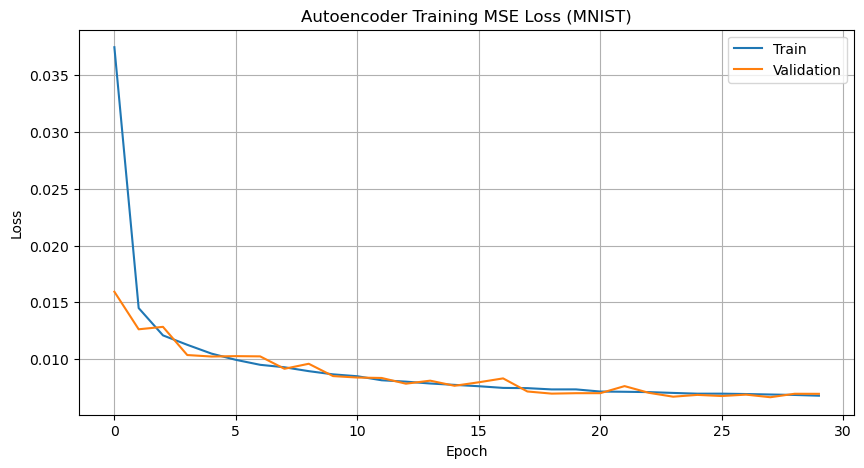

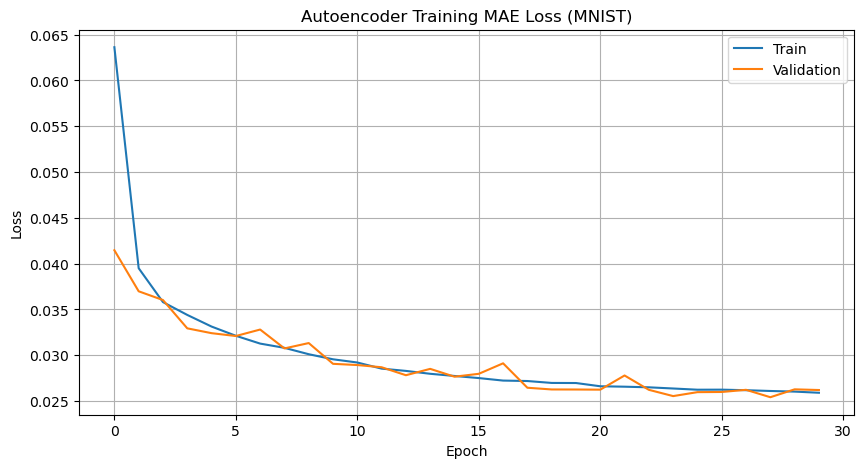

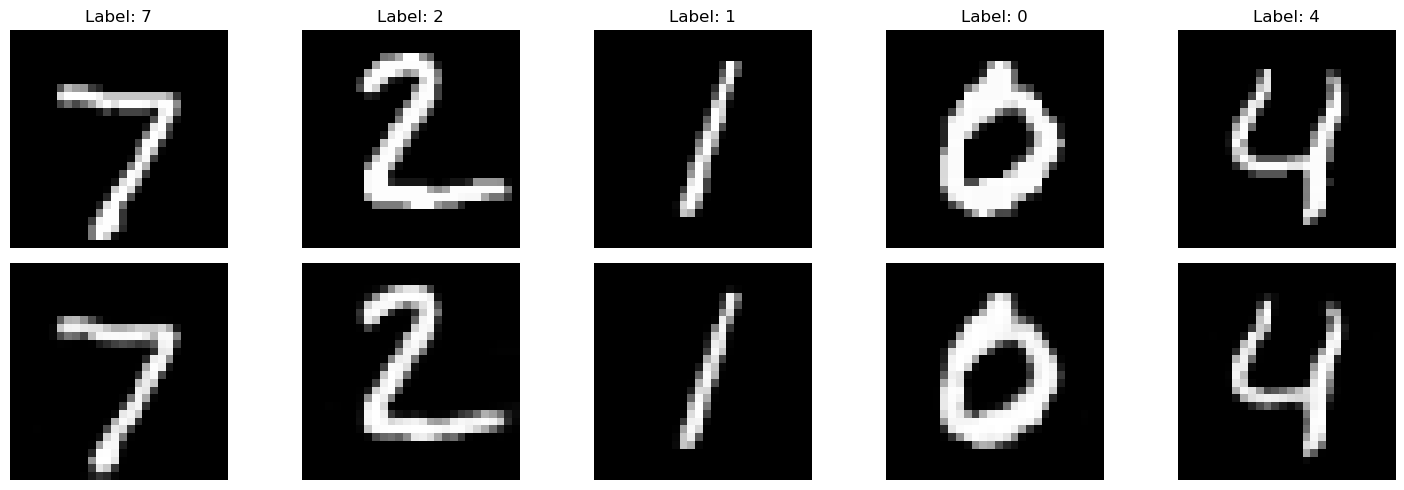

In [10]:
# ## Cell 10: Train Autoencoder (Section 1.2.1 - Self-Supervised)

# In[10]:


# Train autoencoder
print("\n--- Training Autoencoder (Self-Supervised) ---")
autoencoder, mse_losses, mae_losses, val_mse_losses, val_mae_losses = train_autoencoder(
    autoencoder, train_loader, val_loader, EPOCHS_AE, device,
    lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

# Plot training curves
plot_training_curve(
    mse_losses, val_mse_losses,
    f'Autoencoder Training MSE Loss ({("MNIST" if use_mnist else "CIFAR10")})',
    'Loss',
    save_path=f'autoencoder_mse_loss_{("mnist" if use_mnist else "cifar10")}.png'
)

plot_training_curve(
    mae_losses, val_mae_losses,
    f'Autoencoder Training MAE Loss ({("MNIST" if use_mnist else "CIFAR10")})',
    'Loss',
    save_path=f'autoencoder_mae_loss_{("mnist" if use_mnist else "cifar10")}.png'
)

# Plot reconstructions
orig_images, orig_labels = plot_reconstructions(
    autoencoder, test_loader, device, num_samples=5,
    save_path=f'reconstructions_{("mnist" if use_mnist else "cifar10")}.png'
)


--- Performing Linear Interpolation in Latent Space ---


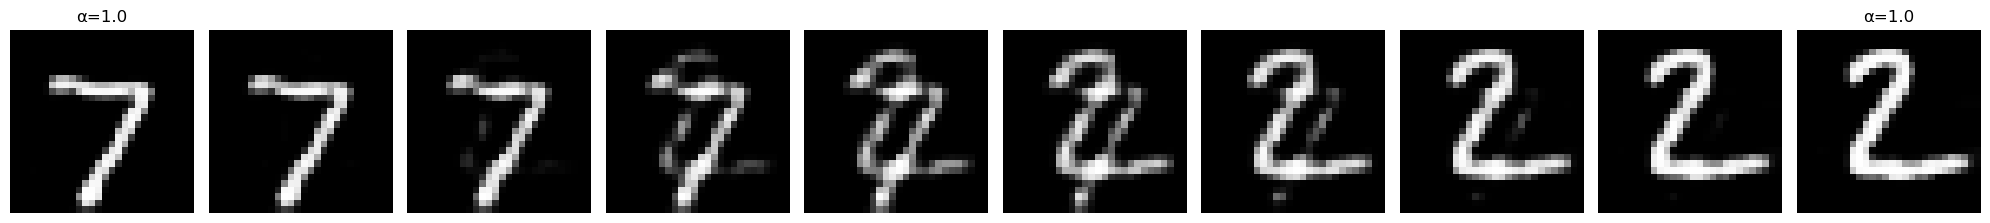

In [11]:
# ## Cell 11: Linear Interpolation (for MNIST - Section 1.2.1)

# In[11]:


if use_mnist:
    print("\n--- Performing Linear Interpolation in Latent Space ---")
    # Select 2 images from the previously visualized ones
    img1 = torch.from_numpy(orig_images[0])
    img2 = torch.from_numpy(orig_images[1])
    
    # Perform interpolation
    latent_interpolation(
        encoder, decoder, img1, img2, steps=10, device=device,
        save_path=f'interpolation_mnist.png'
    )


--- Training Classifier on Encoder's Representations ---


Epoch 1/20: 100%|██████████| 844/844 [00:13<00:00, 63.83it/s]


Epoch [1/20], Train Loss: 0.265878, Train Acc: 92.89%, Val Loss: 0.116085, Val Acc: 96.68%


Epoch 2/20: 100%|██████████| 844/844 [00:13<00:00, 64.01it/s]


Epoch [2/20], Train Loss: 0.094232, Train Acc: 97.15%, Val Loss: 0.099312, Val Acc: 97.08%


Epoch 3/20: 100%|██████████| 844/844 [00:13<00:00, 64.25it/s]


Epoch [3/20], Train Loss: 0.063767, Train Acc: 97.97%, Val Loss: 0.085323, Val Acc: 97.48%


Epoch 4/20: 100%|██████████| 844/844 [00:13<00:00, 64.06it/s]


Epoch [4/20], Train Loss: 0.047902, Train Acc: 98.49%, Val Loss: 0.080136, Val Acc: 97.52%


Epoch 5/20: 100%|██████████| 844/844 [00:13<00:00, 64.00it/s]


Epoch [5/20], Train Loss: 0.038897, Train Acc: 98.71%, Val Loss: 0.083957, Val Acc: 97.58%


Epoch 6/20: 100%|██████████| 844/844 [00:13<00:00, 64.00it/s]


Epoch [6/20], Train Loss: 0.032756, Train Acc: 98.92%, Val Loss: 0.080074, Val Acc: 97.73%


Epoch 7/20: 100%|██████████| 844/844 [00:13<00:00, 63.84it/s]


Epoch [7/20], Train Loss: 0.027090, Train Acc: 99.11%, Val Loss: 0.095054, Val Acc: 97.52%


Epoch 8/20: 100%|██████████| 844/844 [00:13<00:00, 63.92it/s]


Epoch [8/20], Train Loss: 0.027502, Train Acc: 99.05%, Val Loss: 0.086157, Val Acc: 97.72%


Epoch 9/20: 100%|██████████| 844/844 [00:13<00:00, 63.73it/s]


Epoch [9/20], Train Loss: 0.022392, Train Acc: 99.25%, Val Loss: 0.081961, Val Acc: 97.68%


Epoch 10/20: 100%|██████████| 844/844 [00:13<00:00, 63.96it/s]


Epoch [10/20], Train Loss: 0.016988, Train Acc: 99.44%, Val Loss: 0.093678, Val Acc: 97.77%


Epoch 11/20: 100%|██████████| 844/844 [00:13<00:00, 63.71it/s]


Epoch [11/20], Train Loss: 0.017220, Train Acc: 99.42%, Val Loss: 0.087508, Val Acc: 97.82%


Epoch 12/20: 100%|██████████| 844/844 [00:13<00:00, 63.92it/s]


Epoch [12/20], Train Loss: 0.017963, Train Acc: 99.38%, Val Loss: 0.091231, Val Acc: 97.78%


Epoch 13/20: 100%|██████████| 844/844 [00:13<00:00, 63.86it/s]


Epoch [13/20], Train Loss: 0.015890, Train Acc: 99.48%, Val Loss: 0.086081, Val Acc: 97.83%


Epoch 14/20: 100%|██████████| 844/844 [00:12<00:00, 65.23it/s]


Epoch [14/20], Train Loss: 0.015084, Train Acc: 99.50%, Val Loss: 0.082040, Val Acc: 97.95%


Epoch 15/20: 100%|██████████| 844/844 [00:12<00:00, 66.07it/s]


Epoch [15/20], Train Loss: 0.012727, Train Acc: 99.58%, Val Loss: 0.094683, Val Acc: 97.62%


Epoch 16/20: 100%|██████████| 844/844 [00:12<00:00, 66.44it/s]


Epoch [16/20], Train Loss: 0.014306, Train Acc: 99.50%, Val Loss: 0.088988, Val Acc: 97.83%


Epoch 17/20: 100%|██████████| 844/844 [00:12<00:00, 65.85it/s]


Epoch [17/20], Train Loss: 0.010984, Train Acc: 99.64%, Val Loss: 0.088316, Val Acc: 97.83%


Epoch 18/20: 100%|██████████| 844/844 [00:12<00:00, 66.43it/s]


Epoch [18/20], Train Loss: 0.010982, Train Acc: 99.61%, Val Loss: 0.087829, Val Acc: 97.83%


Epoch 19/20: 100%|██████████| 844/844 [00:12<00:00, 66.05it/s]


Epoch [19/20], Train Loss: 0.010414, Train Acc: 99.63%, Val Loss: 0.081493, Val Acc: 98.05%


Epoch 20/20: 100%|██████████| 844/844 [00:12<00:00, 66.30it/s]


Epoch [20/20], Train Loss: 0.011376, Train Acc: 99.62%, Val Loss: 0.084655, Val Acc: 97.87%


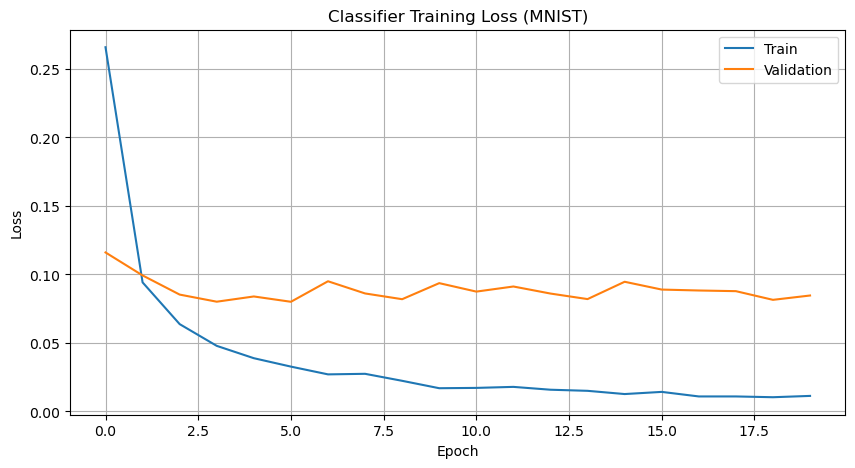

In [12]:
# ## Cell 12: Train Classifier on Frozen Encoder (Section 1.2.1)

# In[12]:


# Train classifier on frozen encoder
print("\n--- Training Classifier on Encoder's Representations ---")
classifier, train_losses, train_accuracies, val_losses, val_accuracies = train_classifier(
    encoder, classifier, train_loader, val_loader, EPOCHS_CLS, device,
    lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

# Plot training curves
plot_training_curve(
    train_losses, val_losses,
    f'Classifier Training Loss ({("MNIST" if use_mnist else "CIFAR10")})',
    'Loss',
    save_path=f'classifier_loss_{("mnist" if use_mnist else "cifar10")}.png'
)

plot_training_curve(
    train_accuracies, val_accuracies,
    f'Classifier Training Accuracy ({("MNIST" if use_mnist else "CIFAR10")})',
    'Accuracy (%)',
    save_path=f'classifier_accuracy_{("mnist" if use_mnist else "cifar10")}.png'
)


--- Evaluating Classifier ---


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 62.66it/s]


Test Accuracy: 97.72%

--- Computing t-SNE Visualization ---


Computing t-SNE for latent space...


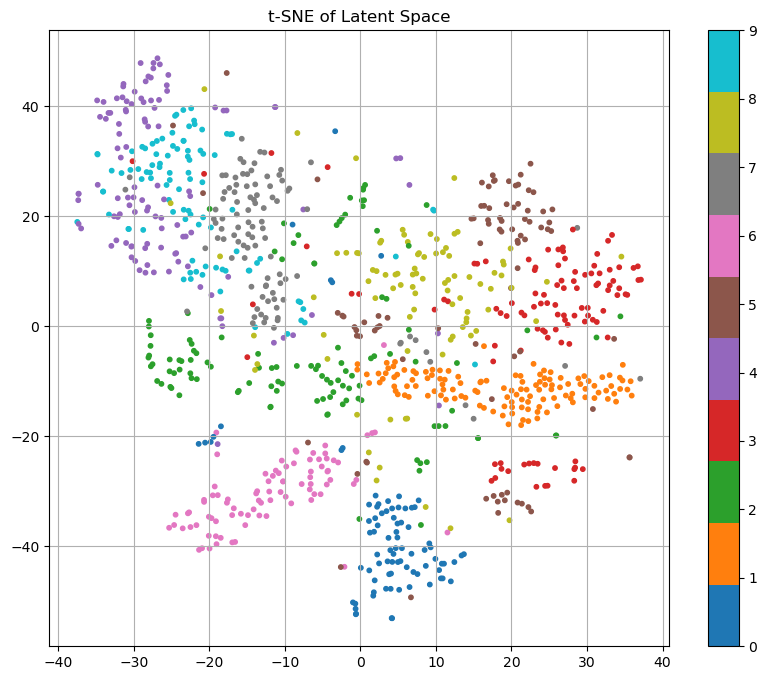

Computing t-SNE for image space...



--- Summary (Self-Supervised Approach) ---
Dataset: MNIST
Latent Dimension: 128
Autoencoder Final MSE Loss: 0.006771
Autoencoder Final MAE Loss: 0.025905
Classifier Train Accuracy: 99.62%
Classifier Validation Accuracy: 97.87%
Classifier Test Accuracy: 97.72%


In [13]:
# ## Cell 13: Evaluate Classifier and Visualize t-SNE (Section 1.2.1)

# In[13]:


# Evaluate on test set
print("\n--- Evaluating Classifier ---")
test_accuracy = evaluate_classifier(encoder, classifier, test_loader, device)

# Plot t-SNE visualization 
print("\n--- Computing t-SNE Visualization ---")
custom_plot_tsne(
    encoder, test_loader, device, n_samples=1000,
    save_path_latent=f'latent_tsne_{("mnist" if use_mnist else "cifar10")}_self_supervised.png',
    save_path_image=f'image_tsne_{("mnist" if use_mnist else "cifar10")}_self_supervised.png'
)

# Print summary
print("\n--- Summary (Self-Supervised Approach) ---")
print(f"Dataset: {('MNIST' if use_mnist else 'CIFAR10')}")
print(f"Latent Dimension: {LATENT_DIM}")
print(f"Autoencoder Final MSE Loss: {mse_losses[-1]:.6f}")
print(f"Autoencoder Final MAE Loss: {mae_losses[-1]:.6f}")
print(f"Classifier Train Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Classifier Validation Accuracy: {val_accuracies[-1]:.2f}%")
print(f"Classifier Test Accuracy: {test_accuracy:.2f}%")

In [14]:
# ## Cell 14: Classification-Guided Encoding Setup (Section 1.2.2)

# In[14]:


# Reset models for Classification-Guided approach
print("\n--- Setting up Classification-Guided Encoding ---")

# Initialize new models
encoder_cls_guided = Encoder(in_channels, LATENT_DIM).to(device)
classifier_cls_guided = Classifier(LATENT_DIM, NUM_CLASSES).to(device)

# Combined training for classification-guided encoding
def train_cls_guided(encoder, classifier, train_loader, val_loader, num_epochs, device, lr=1e-3, weight_decay=1e-5):
    """
    Train the encoder and classifier jointly for classification.
    """
    # Optimize both encoder and classifier parameters
    params = list(encoder.parameters()) + list(classifier.parameters())
    optimizer = optim.Adam(params, lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training
        encoder.train()
        classifier.train()
        epoch_loss = 0.0
        correct = 0
        total = 0
        num_batches = 0
        
        for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            data, targets = data.to(device), targets.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass through encoder and classifier
            latent = encoder(data)
            outputs = classifier(latent)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        avg_epoch_loss = epoch_loss / num_batches
        epoch_accuracy = 100.0 * correct / total
        
        train_losses.append(avg_epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        # Validation
        encoder.eval()
        classifier.eval()
        val_epoch_loss = 0.0
        val_correct = 0
        val_total = 0
        val_num_batches = 0
        
        with torch.no_grad():
            for val_data, val_targets in val_loader:
                val_data, val_targets = val_data.to(device), val_targets.to(device)
                
                val_latent = encoder(val_data)
                val_outputs = classifier(val_latent)
                val_loss = criterion(val_outputs, val_targets)
                
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_targets.size(0)
                val_correct += (val_predicted == val_targets).sum().item()
                
                val_epoch_loss += val_loss.item()
                val_num_batches += 1
        
        avg_val_epoch_loss = val_epoch_loss / val_num_batches
        val_epoch_accuracy = 100.0 * val_correct / val_total
        
        val_losses.append(avg_val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_epoch_loss:.6f}, Train Acc: {epoch_accuracy:.2f}%, Val Loss: {avg_val_epoch_loss:.6f}, Val Acc: {val_epoch_accuracy:.2f}%")
    
    return encoder, classifier, train_losses, train_accuracies, val_losses, val_accuracies


--- Setting up Classification-Guided Encoding ---



--- Training Classification-Guided Models ---


Epoch 1/20: 100%|██████████| 844/844 [00:15<00:00, 54.14it/s]


Epoch [1/20], Train Loss: 0.148838, Train Acc: 95.88%, Val Loss: 0.066407, Val Acc: 97.90%


Epoch 2/20: 100%|██████████| 844/844 [00:15<00:00, 54.34it/s]


Epoch [2/20], Train Loss: 0.059143, Train Acc: 98.21%, Val Loss: 0.057228, Val Acc: 98.17%


Epoch 3/20: 100%|██████████| 844/844 [00:15<00:00, 54.25it/s]


Epoch [3/20], Train Loss: 0.042662, Train Acc: 98.63%, Val Loss: 0.048279, Val Acc: 98.72%


Epoch 4/20: 100%|██████████| 844/844 [00:15<00:00, 54.19it/s]


Epoch [4/20], Train Loss: 0.035245, Train Acc: 98.92%, Val Loss: 0.038005, Val Acc: 98.77%


Epoch 5/20: 100%|██████████| 844/844 [00:15<00:00, 53.50it/s]


Epoch [5/20], Train Loss: 0.027356, Train Acc: 99.14%, Val Loss: 0.043073, Val Acc: 98.78%


Epoch 6/20: 100%|██████████| 844/844 [00:15<00:00, 54.13it/s]


Epoch [6/20], Train Loss: 0.026395, Train Acc: 99.17%, Val Loss: 0.040161, Val Acc: 98.72%


Epoch 7/20: 100%|██████████| 844/844 [00:15<00:00, 54.32it/s]


Epoch [7/20], Train Loss: 0.022083, Train Acc: 99.30%, Val Loss: 0.039334, Val Acc: 98.82%


Epoch 8/20: 100%|██████████| 844/844 [00:15<00:00, 54.27it/s]


Epoch [8/20], Train Loss: 0.019364, Train Acc: 99.37%, Val Loss: 0.061219, Val Acc: 98.48%


Epoch 9/20: 100%|██████████| 844/844 [00:15<00:00, 54.05it/s]


Epoch [9/20], Train Loss: 0.017218, Train Acc: 99.40%, Val Loss: 0.046357, Val Acc: 98.65%


Epoch 10/20: 100%|██████████| 844/844 [00:15<00:00, 54.20it/s]


Epoch [10/20], Train Loss: 0.015830, Train Acc: 99.45%, Val Loss: 0.041725, Val Acc: 98.75%


Epoch 11/20: 100%|██████████| 844/844 [00:15<00:00, 54.26it/s]


Epoch [11/20], Train Loss: 0.013288, Train Acc: 99.59%, Val Loss: 0.042594, Val Acc: 98.82%


Epoch 12/20: 100%|██████████| 844/844 [00:15<00:00, 54.00it/s]


Epoch [12/20], Train Loss: 0.013515, Train Acc: 99.54%, Val Loss: 0.043074, Val Acc: 98.97%


Epoch 13/20: 100%|██████████| 844/844 [00:15<00:00, 54.28it/s]


Epoch [13/20], Train Loss: 0.012409, Train Acc: 99.62%, Val Loss: 0.041886, Val Acc: 98.77%


Epoch 14/20: 100%|██████████| 844/844 [00:15<00:00, 56.13it/s]


Epoch [14/20], Train Loss: 0.011444, Train Acc: 99.59%, Val Loss: 0.047571, Val Acc: 98.70%


Epoch 15/20: 100%|██████████| 844/844 [00:15<00:00, 55.61it/s]


Epoch [15/20], Train Loss: 0.010690, Train Acc: 99.68%, Val Loss: 0.040493, Val Acc: 98.75%


Epoch 16/20: 100%|██████████| 844/844 [00:15<00:00, 55.81it/s]


Epoch [16/20], Train Loss: 0.010509, Train Acc: 99.64%, Val Loss: 0.040780, Val Acc: 98.73%


Epoch 17/20: 100%|██████████| 844/844 [00:15<00:00, 55.96it/s]


Epoch [17/20], Train Loss: 0.009235, Train Acc: 99.69%, Val Loss: 0.038248, Val Acc: 98.93%


Epoch 18/20: 100%|██████████| 844/844 [00:15<00:00, 54.78it/s]


Epoch [18/20], Train Loss: 0.009295, Train Acc: 99.70%, Val Loss: 0.037895, Val Acc: 98.93%


Epoch 19/20: 100%|██████████| 844/844 [00:15<00:00, 53.61it/s]


Epoch [19/20], Train Loss: 0.007300, Train Acc: 99.77%, Val Loss: 0.041861, Val Acc: 98.97%


Epoch 20/20: 100%|██████████| 844/844 [00:15<00:00, 53.91it/s]


Epoch [20/20], Train Loss: 0.010482, Train Acc: 99.66%, Val Loss: 0.044511, Val Acc: 98.88%


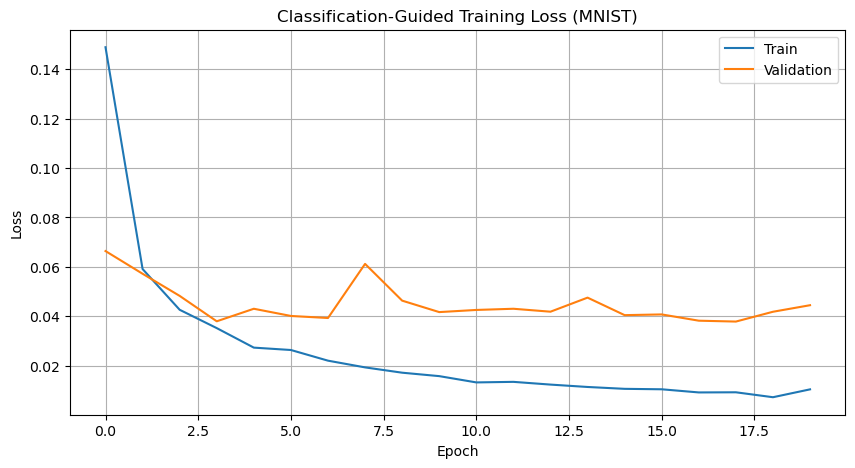

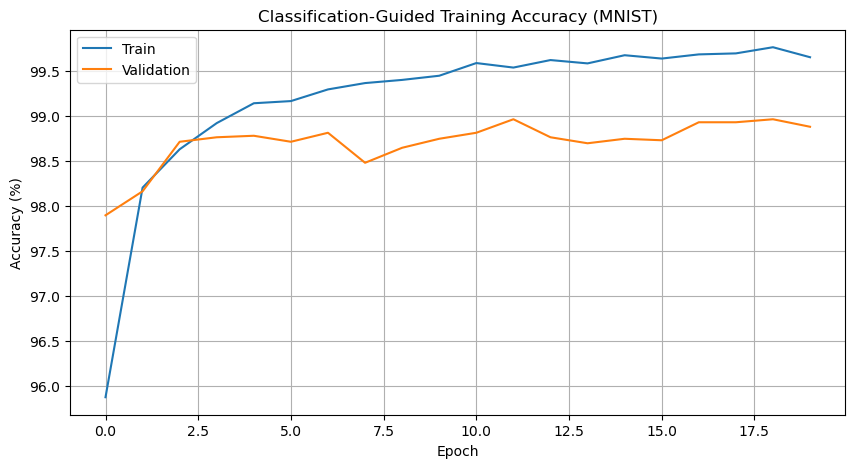


--- Evaluating Classification-Guided Model ---


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 62.09it/s]


Test Accuracy: 98.94%

--- Computing t-SNE Visualization for Classification-Guided Encoding ---


Computing t-SNE for latent space...


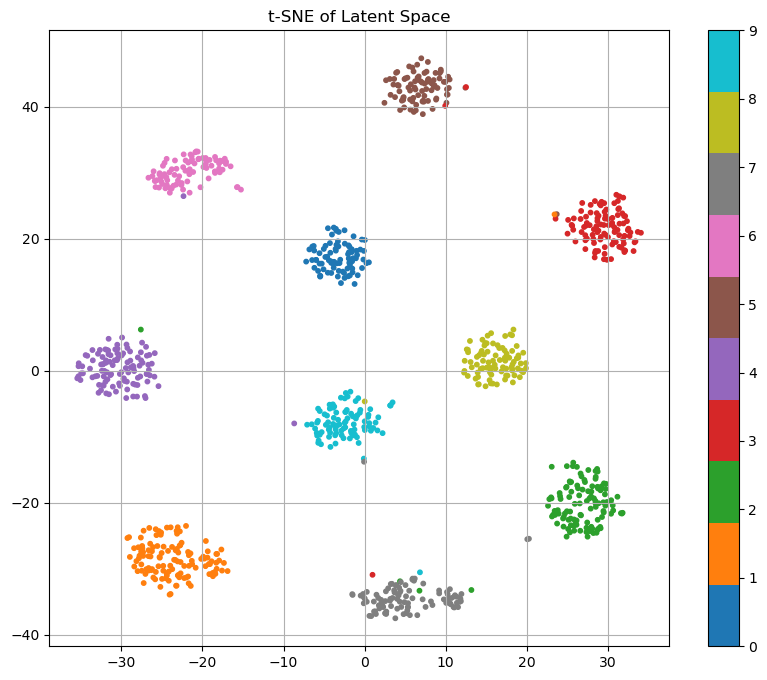

Computing t-SNE for image space...


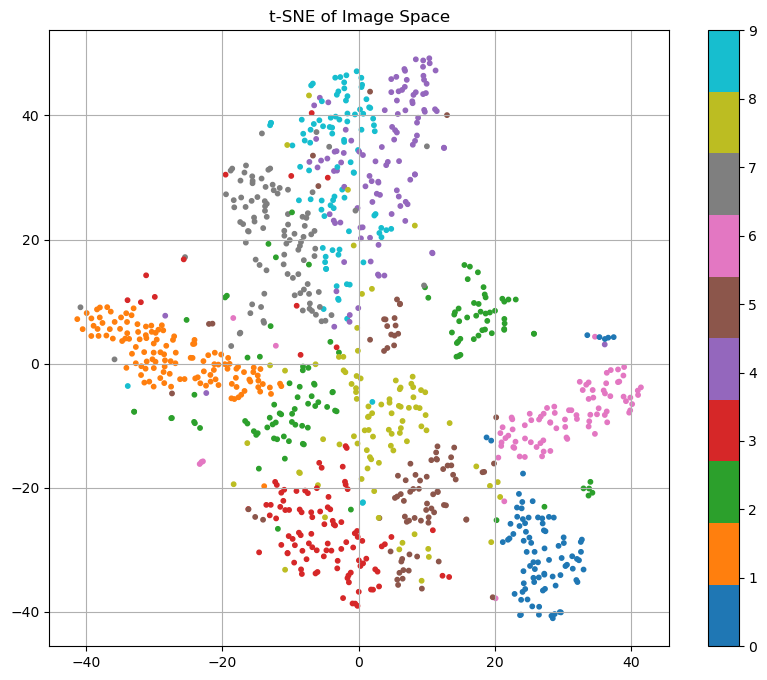


--- Summary (Classification-Guided Approach) ---
Dataset: MNIST
Latent Dimension: 128
Classifier Train Accuracy: 99.66%
Classifier Validation Accuracy: 98.88%
Classifier Test Accuracy: 98.94%


In [15]:
# ## Cell 15: Train Classification-Guided Models (Section 1.2.2)

# In[15]:


# Train classification-guided models
print("\n--- Training Classification-Guided Models ---")
encoder_cls_guided, classifier_cls_guided, cls_train_losses, cls_train_accuracies, cls_val_losses, cls_val_accuracies = train_cls_guided(
    encoder_cls_guided, classifier_cls_guided, train_loader, val_loader, EPOCHS_CLS, device,
    lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

# Plot training curves
plot_training_curve(
    cls_train_losses, cls_val_losses,
    f'Classification-Guided Training Loss ({("MNIST" if use_mnist else "CIFAR10")})',
    'Loss',
    save_path=f'cls_guided_loss_{("mnist" if use_mnist else "cifar10")}.png'
)

plot_training_curve(
    cls_train_accuracies, cls_val_accuracies,
    f'Classification-Guided Training Accuracy ({("MNIST" if use_mnist else "CIFAR10")})',
    'Accuracy (%)',
    save_path=f'cls_guided_accuracy_{("mnist" if use_mnist else "cifar10")}.png'
)

# Evaluate on test set
print("\n--- Evaluating Classification-Guided Model ---")
cls_guided_test_accuracy = evaluate_classifier(encoder_cls_guided, classifier_cls_guided, test_loader, device)

# Plot t-SNE visualization
print("\n--- Computing t-SNE Visualization for Classification-Guided Encoding ---")
custom_plot_tsne(
    encoder_cls_guided, test_loader, device, n_samples=1000,
    save_path_latent=f'latent_tsne_{("mnist" if use_mnist else "cifar10")}_cls_guided.png',
    save_path_image=f'image_tsne_{("mnist" if use_mnist else "cifar10")}_cls_guided.png'
)

# Print summary
print("\n--- Summary (Classification-Guided Approach) ---")
print(f"Dataset: {('MNIST' if use_mnist else 'CIFAR10')}")
print(f"Latent Dimension: {LATENT_DIM}")
print(f"Classifier Train Accuracy: {cls_train_accuracies[-1]:.2f}%")
print(f"Classifier Validation Accuracy: {cls_val_accuracies[-1]:.2f}%")
print(f"Classifier Test Accuracy: {cls_guided_test_accuracy:.2f}%")

In [18]:
# ## Cell 16: Structured Latent Space with Contrastive Learning (Section 1.2.3)

# In[16]:


# Implementation of structured latent space with contrastive learning
class ContrastiveAutoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(ContrastiveAutoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.temperature = 0.5  # Temperature parameter for NT-Xent loss
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent
    
    def contrastive_loss(self, latent_1, latent_2, labels=None):
        """
        Computes contrastive loss for pairs of latent vectors.
        If labels are provided, uses supervised contrastive loss (same class = positive pair).
        Otherwise, uses self-supervised mode (same image with different augmentations = positive pair).
        """
        batch_size = latent_1.size(0)
        
        # Normalize latent vectors
        latent_1 = F.normalize(latent_1, p=2, dim=1)
        latent_2 = F.normalize(latent_2, p=2, dim=1)
        
        # Compute similarity matrix
        similarity_matrix = torch.matmul(latent_1, latent_2.T) / self.temperature
        
        if labels is not None:
            # Supervised contrastive loss - positive pairs are from same class
            # Create a mask for positive pairs (same class)
            labels = labels.view(-1, 1)
            mask_pos = torch.eq(labels, labels.T).float()
            
            # Remove self-pairs from positives
            mask_self = torch.eye(batch_size, device=latent_1.device)
            mask_pos = mask_pos - mask_self
            
            # Ensure each row has at least one positive
            mask_pos_sum = mask_pos.sum(1)
            mask_pos_sum = torch.where(mask_pos_sum > 0, mask_pos_sum, torch.ones_like(mask_pos_sum))
            
            # Calculate loss
            exp_sim = torch.exp(similarity_matrix)
            log_prob = similarity_matrix - torch.log(exp_sim.sum(1, keepdim=True))
            loss = (mask_pos * log_prob).sum(1) / mask_pos_sum
            loss = -loss.mean()
        else:
            # Self-supervised case - assume diagonal elements are positive pairs
            # This would be appropriate if latent_1 and latent_2 are augmentations of the same images
            mask_pos = torch.eye(batch_size, device=latent_1.device)
            
            # Calculate loss
            exp_sim = torch.exp(similarity_matrix)
            log_prob = torch.diag(similarity_matrix) - torch.log(exp_sim.sum(1))
            loss = -log_prob.mean()
            
        return loss

# Define image augmentation for contrastive learning
contrastive_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5] if use_mnist else [0.5, 0.5, 0.5], 
                        std=[0.5] if use_mnist else [0.5, 0.5, 0.5]),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.15))
])

class ContrastiveDataset:
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        
        # For MNIST and CIFAR, img is already a tensor from the original dataset
        # Convert back to PIL for additional augmentations
        # First denormalize: x = x * std + mean
        if isinstance(img, torch.Tensor):
            if img.shape[0] == 1:  # MNIST
                denorm_img = img * 0.5 + 0.5  # Convert from [-1,1] to [0,1]
                pil_img = transforms.ToPILImage()(denorm_img)
            else:  # CIFAR
                denorm_img = img * 0.5 + 0.5  # Convert from [-1,1] to [0,1]
                pil_img = transforms.ToPILImage()(denorm_img)
        else:
            pil_img = img  # Already a PIL image
        
        # Create two differently augmented versions of the same image
        if self.transform:
            aug1 = self.transform(pil_img)
            aug2 = self.transform(pil_img)
            return aug1, aug2, label
        else:
            # Just convert back to tensor if no transform
            tensor_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5] if use_mnist else [0.5, 0.5, 0.5], 
                                   std=[0.5] if use_mnist else [0.5, 0.5, 0.5])
            ])
            return tensor_transform(pil_img), tensor_transform(pil_img), label
        
    def __len__(self):
        return len(self.dataset)

# Define improved image augmentation for contrastive learning
contrastive_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5] if use_mnist else [0.5, 0.5, 0.5], 
                       std=[0.5] if use_mnist else [0.5, 0.5, 0.5])
])

# Create contrastive datasets and dataloaders
contrastive_train_dataset = ContrastiveDataset(train_dataset.dataset, contrastive_transform)
contrastive_train_loader = DataLoader(
    contrastive_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)


--- Training Contrastive Autoencoder ---


Epoch 1/30: 100%|██████████| 938/938 [00:53<00:00, 17.43it/s]


Epoch [1/30], Combined Loss: 1.584489, Rec Loss: 0.141240, Con Loss: 3.027738, Val Loss: 0.054455


Epoch 2/30: 100%|██████████| 938/938 [00:56<00:00, 16.65it/s]


Epoch [2/30], Combined Loss: 1.445161, Rec Loss: 0.055443, Con Loss: 2.834879, Val Loss: 0.040307


Epoch 3/30: 100%|██████████| 938/938 [00:57<00:00, 16.43it/s]


Epoch [3/30], Combined Loss: 1.420360, Rec Loss: 0.047638, Con Loss: 2.793082, Val Loss: 0.035699


Epoch 4/30: 100%|██████████| 938/938 [00:57<00:00, 16.21it/s]


Epoch [4/30], Combined Loss: 1.406255, Rec Loss: 0.044734, Con Loss: 2.767776, Val Loss: 0.034388


Epoch 5/30: 100%|██████████| 938/938 [00:57<00:00, 16.28it/s]


Epoch [5/30], Combined Loss: 1.396534, Rec Loss: 0.042625, Con Loss: 2.750443, Val Loss: 0.033608


Epoch 6/30: 100%|██████████| 938/938 [00:55<00:00, 16.94it/s]


Epoch [6/30], Combined Loss: 1.387744, Rec Loss: 0.041981, Con Loss: 2.733508, Val Loss: 0.035640


Epoch 7/30: 100%|██████████| 938/938 [00:56<00:00, 16.62it/s]


Epoch [7/30], Combined Loss: 1.380471, Rec Loss: 0.042013, Con Loss: 2.718929, Val Loss: 0.032791


Epoch 8/30: 100%|██████████| 938/938 [00:56<00:00, 16.73it/s]


Epoch [8/30], Combined Loss: 1.374803, Rec Loss: 0.041621, Con Loss: 2.707985, Val Loss: 0.035622


Epoch 9/30: 100%|██████████| 938/938 [00:56<00:00, 16.70it/s]


Epoch [9/30], Combined Loss: 1.369819, Rec Loss: 0.041185, Con Loss: 2.698453, Val Loss: 0.032618


Epoch 10/30: 100%|██████████| 938/938 [00:56<00:00, 16.49it/s]


Epoch [10/30], Combined Loss: 1.366549, Rec Loss: 0.040760, Con Loss: 2.692338, Val Loss: 0.030117


Epoch 11/30: 100%|██████████| 938/938 [00:57<00:00, 16.35it/s]


Epoch [11/30], Combined Loss: 1.364202, Rec Loss: 0.039929, Con Loss: 2.688475, Val Loss: 0.035983


Epoch 12/30: 100%|██████████| 938/938 [00:57<00:00, 16.32it/s]


Epoch [12/30], Combined Loss: 1.361749, Rec Loss: 0.039574, Con Loss: 2.683924, Val Loss: 0.031740


Epoch 13/30: 100%|██████████| 938/938 [00:57<00:00, 16.39it/s]


Epoch [13/30], Combined Loss: 1.358945, Rec Loss: 0.038682, Con Loss: 2.679208, Val Loss: 0.031086


Epoch 14/30: 100%|██████████| 938/938 [00:55<00:00, 16.88it/s]


Epoch [14/30], Combined Loss: 1.357203, Rec Loss: 0.037814, Con Loss: 2.676593, Val Loss: 0.030285


Epoch 15/30: 100%|██████████| 938/938 [00:55<00:00, 16.84it/s]


Epoch [15/30], Combined Loss: 1.356116, Rec Loss: 0.037381, Con Loss: 2.674850, Val Loss: 0.029296


Epoch 16/30: 100%|██████████| 938/938 [00:57<00:00, 16.39it/s]


Epoch [16/30], Combined Loss: 1.354049, Rec Loss: 0.036685, Con Loss: 2.671413, Val Loss: 0.028989


Epoch 17/30: 100%|██████████| 938/938 [00:57<00:00, 16.23it/s]


Epoch [17/30], Combined Loss: 1.352804, Rec Loss: 0.036230, Con Loss: 2.669379, Val Loss: 0.029723


Epoch 18/30: 100%|██████████| 938/938 [00:58<00:00, 16.13it/s]


Epoch [18/30], Combined Loss: 1.351616, Rec Loss: 0.035644, Con Loss: 2.667589, Val Loss: 0.026143


Epoch 19/30: 100%|██████████| 938/938 [00:57<00:00, 16.27it/s]


Epoch [19/30], Combined Loss: 1.350704, Rec Loss: 0.034976, Con Loss: 2.666431, Val Loss: 0.027922


Epoch 20/30: 100%|██████████| 938/938 [00:56<00:00, 16.70it/s]


Epoch [20/30], Combined Loss: 1.350150, Rec Loss: 0.034621, Con Loss: 2.665679, Val Loss: 0.028561


Epoch 21/30: 100%|██████████| 938/938 [00:55<00:00, 16.99it/s]


Epoch [21/30], Combined Loss: 1.348647, Rec Loss: 0.034194, Con Loss: 2.663100, Val Loss: 0.025880


Epoch 22/30: 100%|██████████| 938/938 [00:55<00:00, 17.03it/s]


Epoch [22/30], Combined Loss: 1.348593, Rec Loss: 0.033656, Con Loss: 2.663531, Val Loss: 0.025058


Epoch 23/30: 100%|██████████| 938/938 [00:56<00:00, 16.75it/s]


Epoch [23/30], Combined Loss: 1.347689, Rec Loss: 0.033516, Con Loss: 2.661863, Val Loss: 0.026160


Epoch 24/30: 100%|██████████| 938/938 [00:57<00:00, 16.32it/s]


Epoch [24/30], Combined Loss: 1.346267, Rec Loss: 0.033126, Con Loss: 2.659408, Val Loss: 0.025581


Epoch 25/30: 100%|██████████| 938/938 [00:58<00:00, 15.95it/s]


Epoch [25/30], Combined Loss: 1.345965, Rec Loss: 0.032845, Con Loss: 2.659086, Val Loss: 0.025319


Epoch 26/30: 100%|██████████| 938/938 [00:58<00:00, 16.00it/s]


Epoch [26/30], Combined Loss: 1.345881, Rec Loss: 0.032292, Con Loss: 2.659471, Val Loss: 0.025656


Epoch 27/30: 100%|██████████| 938/938 [00:58<00:00, 16.11it/s]


Epoch [27/30], Combined Loss: 1.344682, Rec Loss: 0.032046, Con Loss: 2.657319, Val Loss: 0.028231


Epoch 28/30: 100%|██████████| 938/938 [00:58<00:00, 16.06it/s]


Epoch [28/30], Combined Loss: 1.345574, Rec Loss: 0.031945, Con Loss: 2.659203, Val Loss: 0.024050


Epoch 29/30: 100%|██████████| 938/938 [00:58<00:00, 15.94it/s]


Epoch [29/30], Combined Loss: 1.344716, Rec Loss: 0.031702, Con Loss: 2.657730, Val Loss: 0.025991


Epoch 30/30: 100%|██████████| 938/938 [00:58<00:00, 15.98it/s]


Epoch [30/30], Combined Loss: 1.343361, Rec Loss: 0.031444, Con Loss: 2.655278, Val Loss: 0.025002


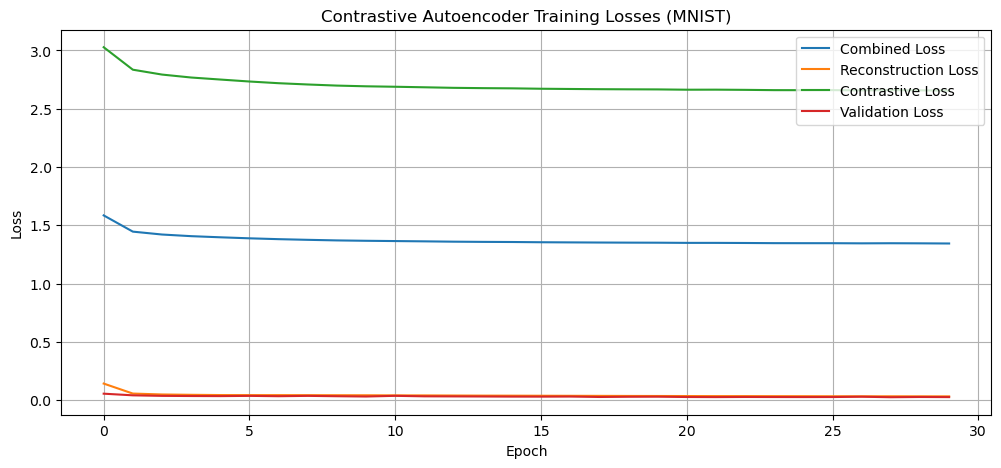

In [19]:
# ## Cell 17: Train Contrastive Encoder (Section 1.2.3)

# In[17]:


# Initialize models for contrastive learning
encoder_contrastive = Encoder(in_channels, LATENT_DIM).to(device)
decoder_contrastive = Decoder(LATENT_DIM, in_channels).to(device)
contrastive_autoencoder = ContrastiveAutoencoder(encoder_contrastive, decoder_contrastive).to(device)

# Training function for contrastive autoencoder
def train_contrastive_autoencoder(model, train_loader, val_loader, num_epochs, device, lr=1e-3, weight_decay=1e-5, alpha=0.5):
    """
    Train the autoencoder model with contrastive learning.
    Alpha controls the balance between reconstruction and contrastive loss.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    mse_criterion = nn.MSELoss()
    
    model.train()
    combined_losses = []
    rec_losses = []
    con_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        epoch_loss = 0.0
        epoch_rec_loss = 0.0
        epoch_con_loss = 0.0
        num_batches = 0
        
        for batch_idx, (img1, img2, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass for both augmentations
            reconstructed1, latent1 = model(img1)
            reconstructed2, latent2 = model(img2)
            
            # Reconstruction loss
            rec_loss1 = mse_criterion(reconstructed1, img1)
            rec_loss2 = mse_criterion(reconstructed2, img2)
            rec_loss = (rec_loss1 + rec_loss2) / 2
            
            # Contrastive loss
            con_loss = model.contrastive_loss(latent1, latent2, labels)
            
            # Combined loss
            loss = (1 - alpha) * rec_loss + alpha * con_loss
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_rec_loss += rec_loss.item()
            epoch_con_loss += con_loss.item()
            num_batches += 1
        
        avg_epoch_loss = epoch_loss / num_batches
        avg_epoch_rec_loss = epoch_rec_loss / num_batches
        avg_epoch_con_loss = epoch_con_loss / num_batches
        
        combined_losses.append(avg_epoch_loss)
        rec_losses.append(avg_epoch_rec_loss)
        con_losses.append(avg_epoch_con_loss)
        
        # Validation - just measure reconstruction loss
        model.eval()
        val_epoch_loss = 0.0
        val_num_batches = 0
        
        with torch.no_grad():
            for val_data, _ in val_loader:
                val_data = val_data.to(device)
                val_reconstructed, _ = model(val_data)
                val_loss = mse_criterion(val_reconstructed, val_data)
                val_epoch_loss += val_loss.item()
                val_num_batches += 1
        
        avg_val_epoch_loss = val_epoch_loss / val_num_batches
        val_losses.append(avg_val_epoch_loss)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Combined Loss: {avg_epoch_loss:.6f}, Rec Loss: {avg_epoch_rec_loss:.6f}, Con Loss: {avg_epoch_con_loss:.6f}, Val Loss: {avg_val_epoch_loss:.6f}")
    
    return model, combined_losses, rec_losses, con_losses, val_losses

# Train contrastive autoencoder
print("\n--- Training Contrastive Autoencoder ---")
contrastive_autoencoder, combined_losses, rec_losses, con_losses, val_losses = train_contrastive_autoencoder(
    contrastive_autoencoder, contrastive_train_loader, val_loader, EPOCHS_AE, device,
    lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, alpha=0.5  # Equal weight to reconstruction and contrastive loss
)

# Plot training curves
plt.figure(figsize=(12, 5))
plt.plot(combined_losses, label='Combined Loss')
plt.plot(rec_losses, label='Reconstruction Loss')
plt.plot(con_losses, label='Contrastive Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title(f'Contrastive Autoencoder Training Losses ({("MNIST" if use_mnist else "CIFAR10")})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.savefig(f'contrastive_losses_{("mnist" if use_mnist else "cifar10")}.png')
plt.show()


--- Training Classifier on Contrastive Encoder's Representations ---


Epoch 1/20: 100%|██████████| 844/844 [00:13<00:00, 61.68it/s]


Epoch [1/20], Train Loss: 0.065036, Train Acc: 98.98%, Val Loss: 0.028726, Val Acc: 99.33%


Epoch 2/20: 100%|██████████| 844/844 [00:13<00:00, 61.50it/s]


Epoch [2/20], Train Loss: 0.029612, Train Acc: 99.23%, Val Loss: 0.028484, Val Acc: 99.32%


Epoch 3/20: 100%|██████████| 844/844 [00:13<00:00, 62.52it/s]


Epoch [3/20], Train Loss: 0.027649, Train Acc: 99.29%, Val Loss: 0.027351, Val Acc: 99.37%


Epoch 4/20: 100%|██████████| 844/844 [00:13<00:00, 62.85it/s]


Epoch [4/20], Train Loss: 0.026690, Train Acc: 99.27%, Val Loss: 0.025826, Val Acc: 99.37%


Epoch 5/20: 100%|██████████| 844/844 [00:13<00:00, 62.81it/s]


Epoch [5/20], Train Loss: 0.025027, Train Acc: 99.32%, Val Loss: 0.024885, Val Acc: 99.45%


Epoch 6/20: 100%|██████████| 844/844 [00:13<00:00, 62.50it/s]


Epoch [6/20], Train Loss: 0.025491, Train Acc: 99.34%, Val Loss: 0.025433, Val Acc: 99.37%


Epoch 7/20: 100%|██████████| 844/844 [00:13<00:00, 62.86it/s]


Epoch [7/20], Train Loss: 0.023848, Train Acc: 99.36%, Val Loss: 0.026715, Val Acc: 99.40%


Epoch 8/20: 100%|██████████| 844/844 [00:13<00:00, 62.77it/s]


Epoch [8/20], Train Loss: 0.023522, Train Acc: 99.37%, Val Loss: 0.024021, Val Acc: 99.37%


Epoch 9/20: 100%|██████████| 844/844 [00:13<00:00, 62.55it/s]


Epoch [9/20], Train Loss: 0.022879, Train Acc: 99.37%, Val Loss: 0.025851, Val Acc: 99.37%


Epoch 10/20: 100%|██████████| 844/844 [00:13<00:00, 62.55it/s]


Epoch [10/20], Train Loss: 0.022796, Train Acc: 99.35%, Val Loss: 0.025945, Val Acc: 99.33%


Epoch 11/20: 100%|██████████| 844/844 [00:13<00:00, 63.21it/s]


Epoch [11/20], Train Loss: 0.021483, Train Acc: 99.38%, Val Loss: 0.027360, Val Acc: 99.25%


Epoch 12/20: 100%|██████████| 844/844 [00:13<00:00, 63.27it/s]


Epoch [12/20], Train Loss: 0.021333, Train Acc: 99.42%, Val Loss: 0.023711, Val Acc: 99.37%


Epoch 13/20: 100%|██████████| 844/844 [00:13<00:00, 63.09it/s]


Epoch [13/20], Train Loss: 0.022349, Train Acc: 99.39%, Val Loss: 0.023848, Val Acc: 99.40%


Epoch 14/20: 100%|██████████| 844/844 [00:13<00:00, 63.28it/s]


Epoch [14/20], Train Loss: 0.021886, Train Acc: 99.38%, Val Loss: 0.025267, Val Acc: 99.38%


Epoch 15/20: 100%|██████████| 844/844 [00:13<00:00, 63.29it/s]


Epoch [15/20], Train Loss: 0.021347, Train Acc: 99.39%, Val Loss: 0.025119, Val Acc: 99.35%


Epoch 16/20: 100%|██████████| 844/844 [00:13<00:00, 62.84it/s]


Epoch [16/20], Train Loss: 0.021102, Train Acc: 99.39%, Val Loss: 0.022197, Val Acc: 99.42%


Epoch 17/20: 100%|██████████| 844/844 [00:13<00:00, 62.64it/s]


Epoch [17/20], Train Loss: 0.020920, Train Acc: 99.39%, Val Loss: 0.024079, Val Acc: 99.40%


Epoch 18/20: 100%|██████████| 844/844 [00:13<00:00, 63.07it/s]


Epoch [18/20], Train Loss: 0.019963, Train Acc: 99.42%, Val Loss: 0.022358, Val Acc: 99.43%


Epoch 19/20: 100%|██████████| 844/844 [00:13<00:00, 63.10it/s]


Epoch [19/20], Train Loss: 0.020070, Train Acc: 99.45%, Val Loss: 0.023599, Val Acc: 99.43%


Epoch 20/20: 100%|██████████| 844/844 [00:13<00:00, 63.24it/s]


Epoch [20/20], Train Loss: 0.019831, Train Acc: 99.46%, Val Loss: 0.024501, Val Acc: 99.45%


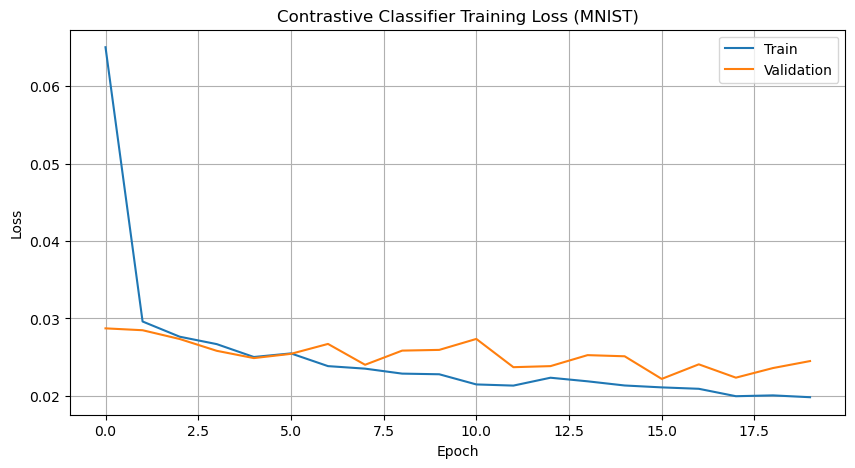

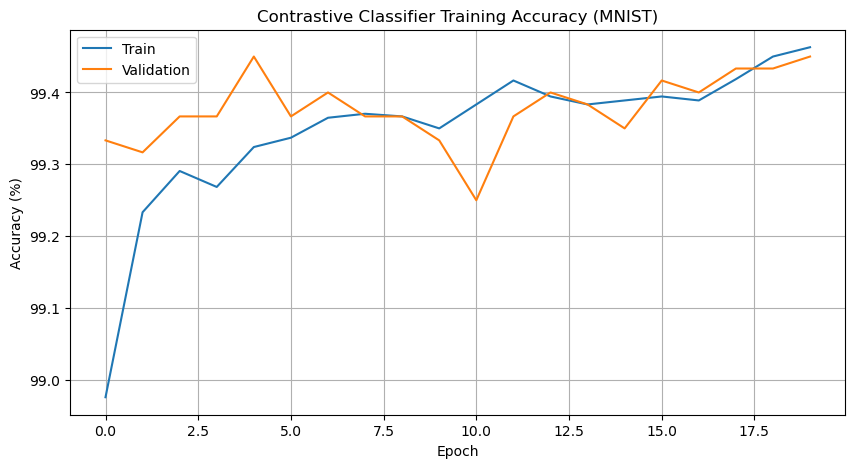


--- Evaluating Contrastive Classifier ---


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 59.50it/s]


Test Accuracy: 99.26%

--- Computing t-SNE Visualization for Contrastive Encoding ---


Computing t-SNE for latent space...


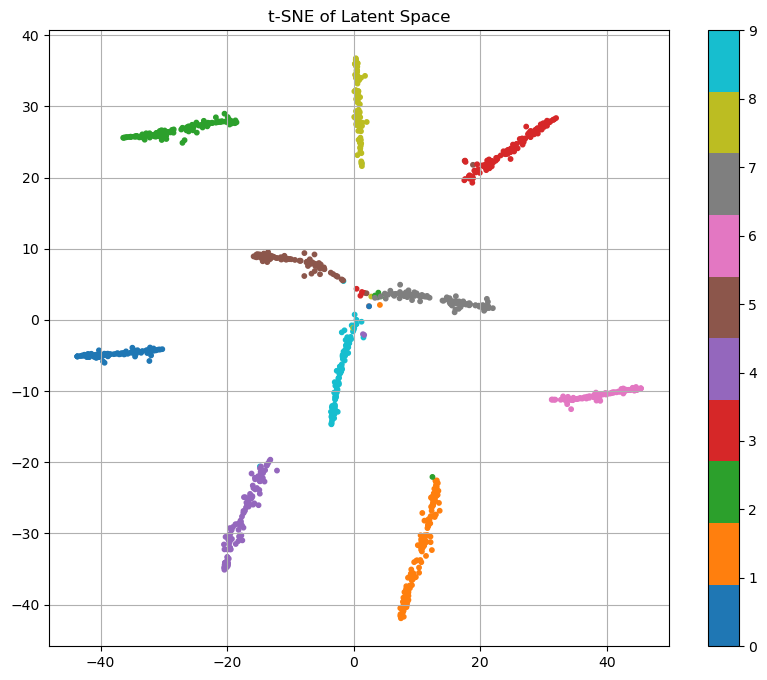

Computing t-SNE for image space...


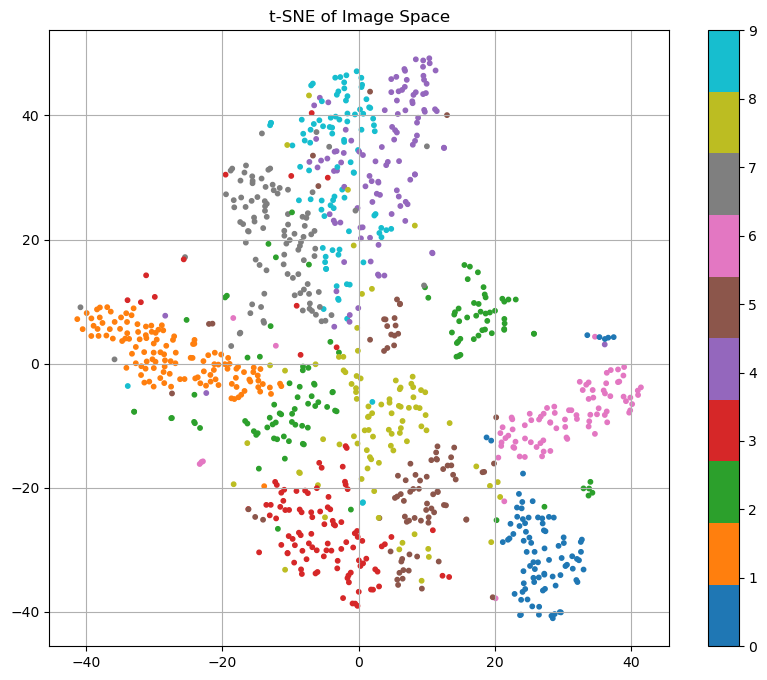


--- Summary (Contrastive Learning Approach) ---
Dataset: MNIST
Latent Dimension: 128
Classifier Train Accuracy: 99.46%
Classifier Validation Accuracy: 99.45%
Classifier Test Accuracy: 99.26%


In [20]:
# ## Cell 18: Train Classifier on Contrastive Encoder (Section 1.2.3)

# In[18]:


# Initialize classifier for contrastive encoder
classifier_contrastive = Classifier(LATENT_DIM, NUM_CLASSES).to(device)

# Train classifier on frozen contrastive encoder
print("\n--- Training Classifier on Contrastive Encoder's Representations ---")
classifier_contrastive, contrastive_train_losses, contrastive_train_accuracies, contrastive_val_losses, contrastive_val_accuracies = train_classifier(
    encoder_contrastive, classifier_contrastive, train_loader, val_loader, EPOCHS_CLS, device,
    lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

# Plot training curves
plot_training_curve(
    contrastive_train_losses, contrastive_val_losses,
    f'Contrastive Classifier Training Loss ({("MNIST" if use_mnist else "CIFAR10")})',
    'Loss',
    save_path=f'contrastive_classifier_loss_{("mnist" if use_mnist else "cifar10")}.png'
)

plot_training_curve(
    contrastive_train_accuracies, contrastive_val_accuracies,
    f'Contrastive Classifier Training Accuracy ({("MNIST" if use_mnist else "CIFAR10")})',
    'Accuracy (%)',
    save_path=f'contrastive_classifier_accuracy_{("mnist" if use_mnist else "cifar10")}.png'
)

# Evaluate on test set
print("\n--- Evaluating Contrastive Classifier ---")
contrastive_test_accuracy = evaluate_classifier(encoder_contrastive, classifier_contrastive, test_loader, device)

# Plot t-SNE visualization
print("\n--- Computing t-SNE Visualization for Contrastive Encoding ---")
custom_plot_tsne(
    encoder_contrastive, test_loader, device, n_samples=1000,
    save_path_latent=f'latent_tsne_{("mnist" if use_mnist else "cifar10")}_contrastive.png',
    save_path_image=f'image_tsne_{("mnist" if use_mnist else "cifar10")}_contrastive.png'
)

# Print summary
print("\n--- Summary (Contrastive Learning Approach) ---")
print(f"Dataset: {('MNIST' if use_mnist else 'CIFAR10')}")
print(f"Latent Dimension: {LATENT_DIM}")
print(f"Classifier Train Accuracy: {contrastive_train_accuracies[-1]:.2f}%")
print(f"Classifier Validation Accuracy: {contrastive_val_accuracies[-1]:.2f}%")
print(f"Classifier Test Accuracy: {contrastive_test_accuracy:.2f}%")


--- Comparison of All Approaches ---


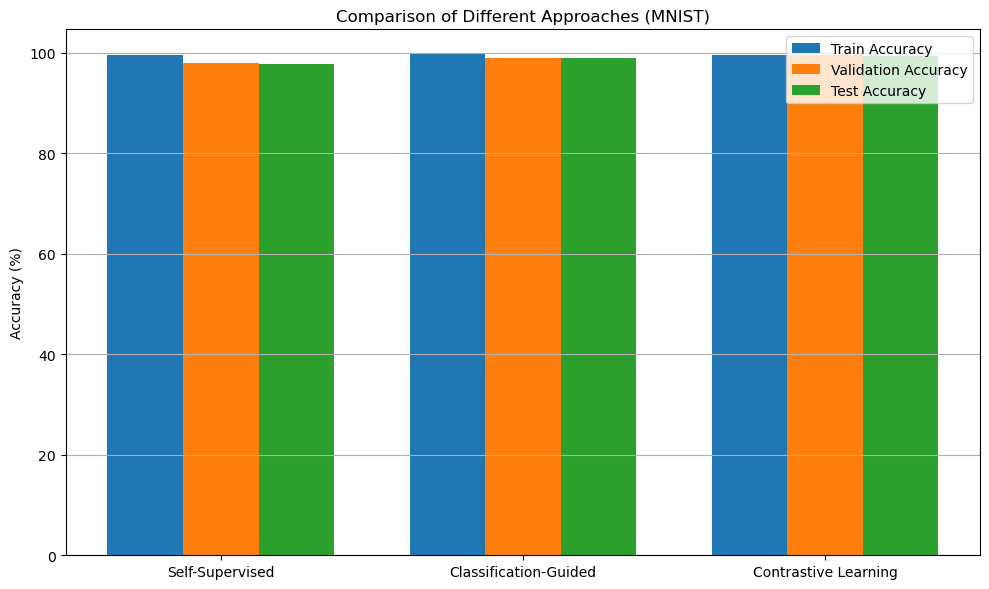


Accuracy Comparison Table:
--------------------------------------------------------------------------------
Method                    Train Accuracy       Val Accuracy         Test Accuracy       
--------------------------------------------------------------------------------
Self-Supervised           99.62                97.87                97.72               
Classification-Guided     99.66                98.88                98.94               
Contrastive Learning      99.46                99.45                99.26               
--------------------------------------------------------------------------------

Completed all experiments for MNIST dataset. To run for CIFAR10, set use_mnist = False in Cell 8 and rerun.


In [21]:
# ## Cell 19: Compare All Three Approaches

# In[19]:


# Compare results from all three approaches
print("\n--- Comparison of All Approaches ---")
methods = ['Self-Supervised', 'Classification-Guided', 'Contrastive Learning']
train_accs = [train_accuracies[-1], cls_train_accuracies[-1], contrastive_train_accuracies[-1]]
val_accs = [val_accuracies[-1], cls_val_accuracies[-1], contrastive_val_accuracies[-1]]
test_accs = [test_accuracy, cls_guided_test_accuracy, contrastive_test_accuracy]

# Plot comparison
plt.figure(figsize=(10, 6))
x = np.arange(len(methods))
width = 0.25

plt.bar(x - width, train_accs, width, label='Train Accuracy')
plt.bar(x, val_accs, width, label='Validation Accuracy')
plt.bar(x + width, test_accs, width, label='Test Accuracy')

plt.ylabel('Accuracy (%)')
plt.title(f'Comparison of Different Approaches ({("MNIST" if use_mnist else "CIFAR10")})')
plt.xticks(x, methods)
plt.legend()
plt.grid(True, axis='y')

plt.tight_layout()
plt.savefig(f'comparison_{("mnist" if use_mnist else "cifar10")}.png')
plt.show()

# Print comparison table
print("\nAccuracy Comparison Table:")
print("-" * 80)
print(f"{'Method':<25} {'Train Accuracy':<20} {'Val Accuracy':<20} {'Test Accuracy':<20}")
print("-" * 80)
for i, method in enumerate(methods):
    print(f"{method:<25} {train_accs[i]:<20.2f} {val_accs[i]:<20.2f} {test_accs[i]:<20.2f}")
print("-" * 80)

# End of notebook for MNIST dataset
print("\nCompleted all experiments for MNIST dataset. To run for CIFAR10, set use_mnist = False in Cell 8 and rerun.")